In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
import libpysal
from spreg import OLS, ML_Lag, ML_Error, GM_Lag 
from esda.moran import Moran
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import skew, kurtosis
import folium
from folium.plugins import MarkerCluster, HeatMap, Fullscreen
from IPython.display import display, IFrame
import libpysal
from esda.moran import Moran
from splot.esda import plot_moran, moran_scatterplot


### PRELIMINARY ANALYSIS

In [2]:
from data_preparation import listings_gdf, pm_gdf, neighbourhoods
full_listings = pd.read_csv("data/listings.csv.gz", compression='gzip')

All neighbourhoods match
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'max

In [ ]:
# coordinates
#32633 sicily utm 33n
#4326 wgs 84
#3857 web mercator

In [2]:
print(f"Total valid entries in Sicily: {listings_gdf.shape[0]}.\nTotal valid entries in Palermo: {pm_gdf.shape[0]}")

Total valid entries in Sicily: 37158.
Total valid entries in Palermo: 5571


In [3]:
listings_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 37158 entries, 0 to 57366
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   price                   37158 non-null  float64 
 1   name                    37158 non-null  object  
 2   geometry                37158 non-null  geometry
 3   room_type               37158 non-null  object  
 4   property_type           37158 non-null  object  
 5   accommodates            37158 non-null  int64   
 6   bedrooms                37158 non-null  float64 
 7   number_of_reviews       37158 non-null  int64   
 8   review_scores_rating    37158 non-null  float64 
 9   host_is_superhost       37158 non-null  object  
 10  neighbourhood_cleansed  37158 non-null  object  
 11  geometry_city           37158 non-null  geometry
 12  log_price               37158 non-null  float64 
dtypes: float64(4), geometry(2), int64(2), object(5)
memory usage: 4.0+ MB


In [4]:
listings_gdf.describe().round(2)

,price,accommodates,bedrooms,number_of_reviews,review_scores_rating,log_price
count,37158.00,37158.00,37158.00,37158.00,37158.00,37158.00
mean,269.42,4.40,1.74,30.15,4.75,4.58
std,1211.02,2.28,1.08,56.34,0.41,0.85
min,8.00,1.00,0.00,1.00,0.00,2.08
25%,60.00,3.00,1.00,3.00,4.67,4.09
50%,83.00,4.00,1.00,9.00,4.88,4.42
75%,125.00,5.00,2.00,32.00,5.00,4.83
max,27635.00,16.00,17.00,845.00,5.00,10.23


In [5]:
pm_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5571 entries, 12 to 57365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   price                   5571 non-null   float64 
 1   geometry                5571 non-null   geometry
 2   room_type               5571 non-null   object  
 3   property_type           5571 non-null   object  
 4   accommodates            5571 non-null   int64   
 5   bedrooms                5571 non-null   float64 
 6   number_of_reviews       5571 non-null   int64   
 7   review_scores_rating    5571 non-null   float64 
 8   host_is_superhost       5571 non-null   object  
 9   neighbourhood_cleansed  5571 non-null   object  
 10  geometry_city           5571 non-null   geometry
 11  log_price               5571 non-null   float64 
dtypes: float64(4), geometry(2), int64(2), object(4)
memory usage: 565.8+ KB


In [5]:
pm_gdf.describe().round(2)

,price,accommodates,bedrooms,number_of_reviews,review_scores_rating,log_price
count,5571.00,5571.00,5571.00,5571.00,5571.00,5571.00
mean,136.68,3.94,1.51,46.57,4.77,4.40
std,609.78,1.98,0.86,76.06,0.35,0.62
min,14.00,1.00,0.00,1.00,1.00,2.64
25%,58.00,2.00,1.00,4.00,4.70,4.06
50%,75.00,4.00,1.00,16.00,4.87,4.32
75%,103.00,5.00,2.00,56.00,5.00,4.63
max,10000.00,16.00,12.00,845.00,5.00,9.21


### DATA VISUALIZATION

##### Correlation analysis: 

$$VIF_i = \frac{1}{1 - R_i^2}$$

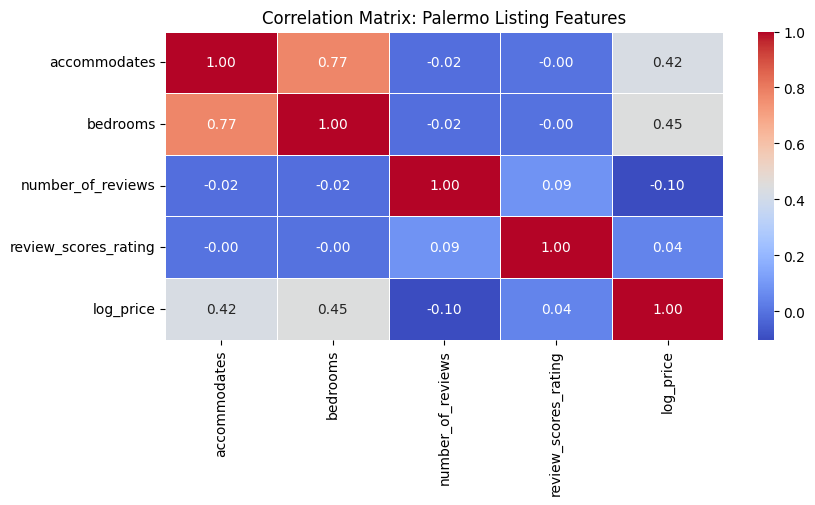

--- VIF Results ---
               Variable       VIF
2              bedrooms  2.499115
1          accommodates  2.499107
3     number_of_reviews  1.007734
4  review_scores_rating  1.007484


In [7]:
# 1. Selection of Variables
# Choose the specific variables you plan to use in your regression
# Example: features + your target log_price
features = ['accommodates', 'bedrooms', 
            'number_of_reviews', 'review_scores_rating']
target = ['log_price']

# Filter data and drop NaNs (VIF/Correlation cannot handle missing values)
analysis_df = pm_gdf[features + target].dropna()

# 2. Correlation Matrix
corr_matrix = analysis_df.corr()

# Plotting the Matrix
plt.figure(figsize=(9, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Palermo Listing Features')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. VIF Calculation
# VIF is calculated on the independent variables (features) only
X = analysis_df[features]
X = add_constant(X) # Statistics require a constant/intercept

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Remove the 'const' row for the final table and sort
vif_table = vif_data[vif_data["Variable"] != 'const'].sort_values(by="VIF", ascending=False)

print("--- VIF Results ---")
print(vif_table)

# Save to CSV for your thesis appendix
vif_table.to_csv('vif_results.csv', index=False)

##### Target analysis

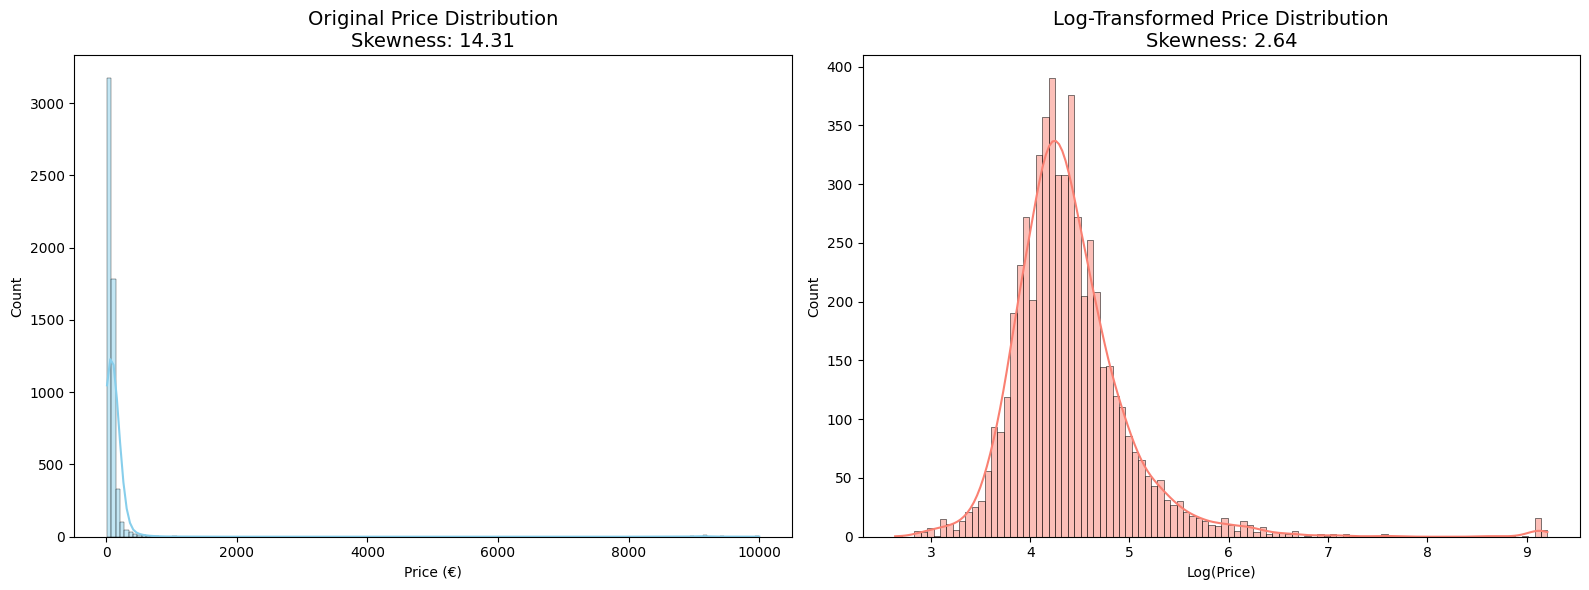

In [29]:
def plot_price_normalization(gdf):
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Plot Raw Price Distribution
    sns.histplot(gdf['price'], kde=True, color='skyblue', ax=ax1)
    ax1.set_title(f"Original Price Distribution\nSkewness: {skew(gdf['price']):.2f}", fontsize=14)
    ax1.set_xlabel("Price (€)")
    
    # 2. Plot Log-Transformed Price Distribution
    # Ensure log_price is calculated (using log1p to handle zeros if any)
    if 'log_price' not in gdf.columns:
        gdf['log_price'] = np.log1p(gdf['price'])
        
    sns.histplot(gdf['log_price'], kde=True, color='salmon', ax=ax2)
    ax2.set_title(f"Log-Transformed Price Distribution\nSkewness: {skew(gdf['log_price']):.2f}", fontsize=14)
    ax2.set_xlabel("Log(Price)")
    
    plt.tight_layout()
    plt.savefig('price_normalization_histogram.png', dpi=300)
    plt.show()

# Run the analysis for Palermo
plot_price_normalization(pm_gdf)

In [37]:
def save_price_heatmap(gdf, filename="palermo_price_heatmap.html"):
    # 1. Ensure WGS84 for Folium
    plot_gdf = gdf.to_crs(epsg=4326)
    
    # 2. Prepare data: [lat, lon, weight]
    # We use 'price' (or 'log_price') as the weight
    heat_data = [[row.geometry.y, row.geometry.x, row.price] for _, row in plot_gdf.iterrows()]
    
    # 3. Initialize Map
    m = folium.Map(location=[38.1157, 13.3615], zoom_start=13, tiles='CartoDB positron')
    
    # 4. Add HeatMap
    HeatMap(
        heat_data,
        radius=15,
        blur=15,
        min_opacity=0.4,
        gradient={0.2: 'blue', 0.5: 'lime', 1: 'red'}
    ).add_to(m)
    
    Fullscreen().add_to(m)
    m.save(filename)
    print(f"Price Heatmap saved to: {filename}")

save_price_heatmap(pm_gdf)

Price Heatmap saved to: palermo_price_heatmap.html


##### Moran analysis

Heatmap saved: palermo_price_heatmap.html


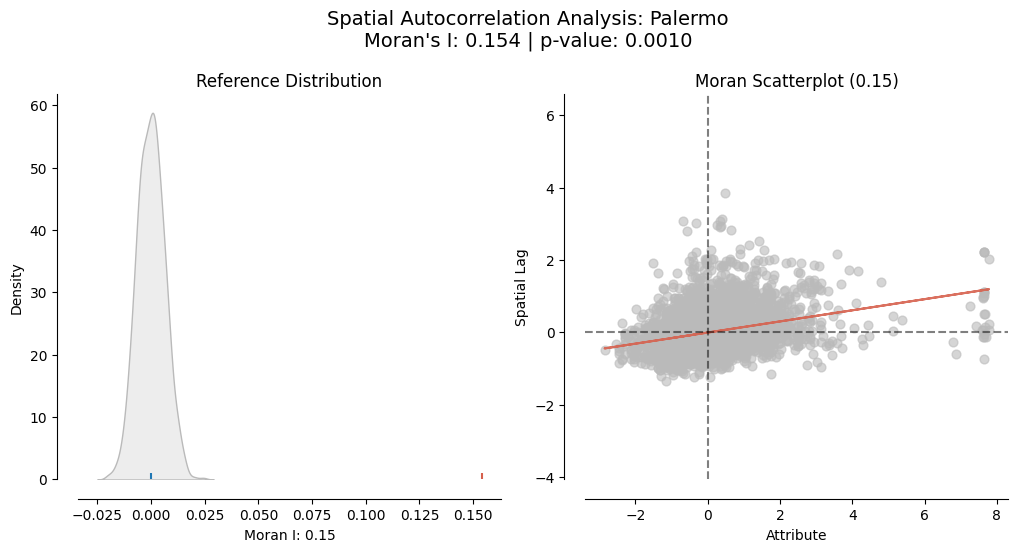

In [ ]:
# --- FUNCTION B: MORAN'S SCATTERPLOT (Fixed TypeError) ---
def run_moran_analysis(gdf):
    # 1. Weights Matrix (KNN=8)
    # The warning about disconnected components is normal for city data
    w = libpysal.weights.KNN.from_dataframe(gdf.to_crs(epsg=32633), k=8)
    w.transform = 'R'
    
    # 2. Global Moran's I
    y = gdf['log_price'].values
    moran = Moran(y, w)
    
    # 3. Corrected Plotting
    # We let plot_moran create its own figure to avoid the 'ax' TypeError
    fig, ax = plot_moran(moran, zstandard=True, figsize=(12, 5))
    
    # Adjust titles for the generated subplots
    plt.suptitle(f"Spatial Autocorrelation Analysis in Palermo\nMoran's I: {moran.I:.3f} | p-value: {moran.p_sim:.4f}", 
                 fontsize=14, y=1.05)
    
    plt.savefig('images/morans_analysis_combined.png', dpi=300, bbox_inches='tight')
    plt.show()
    return moran

# Execute
save_price_heatmap(pm_gdf)
moran_result = run_moran_analysis(pm_gdf)

### MAPS

Map successfully saved as: palermo_density.png


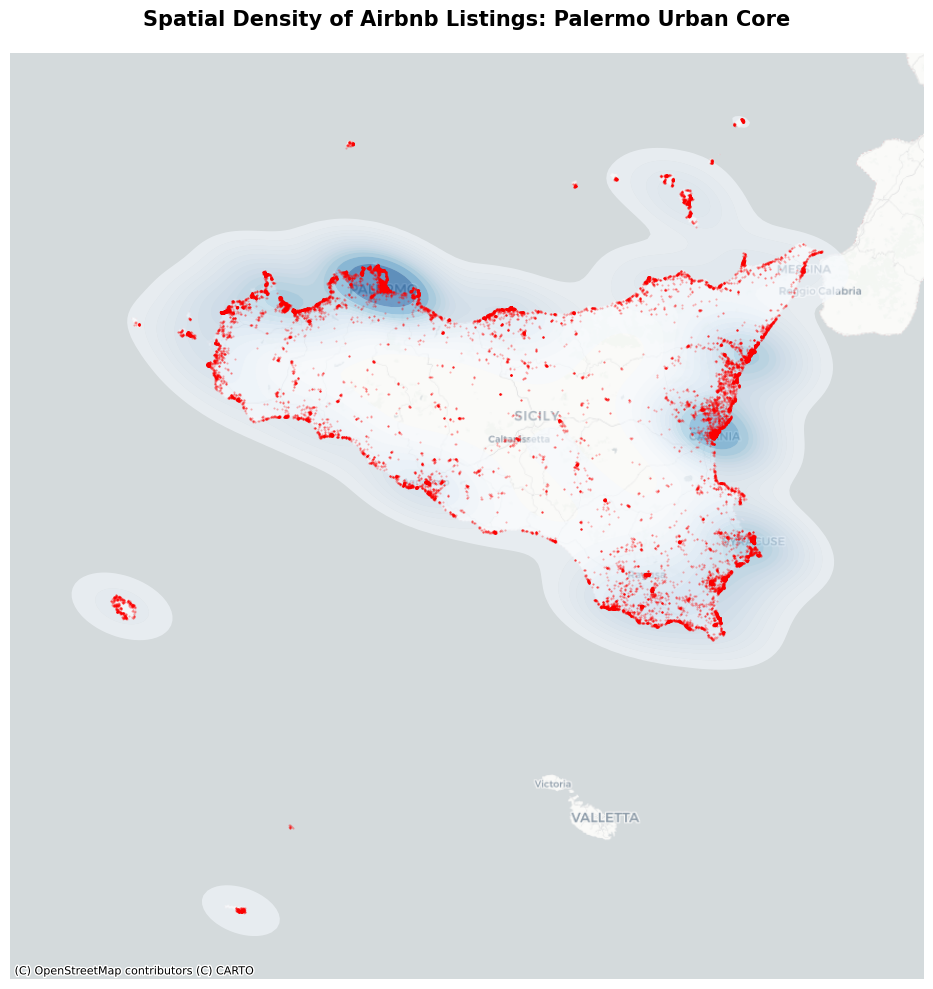

Map successfully saved as: palermo_density.png


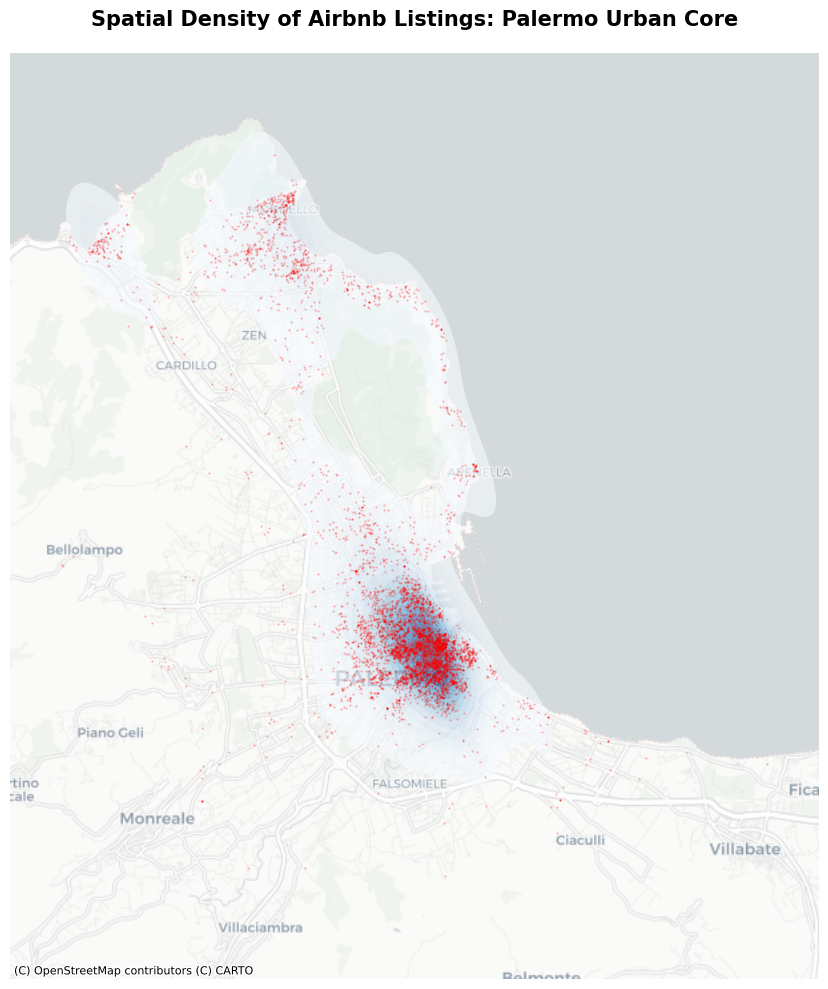

In [ ]:
import contextily as ctx # For the professional background map

def create_academic_density_plot(gdf, title, filename):
    # 1. Project to Web Mercator for the basemap compatibility
    plot_gdf = gdf.to_crs(epsg=3857)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # 2. Plot the smoothed density (KDE)
    # This creates the "blue-to-red" heatmap effect seen in your reference
    sns.kdeplot(
        x=plot_gdf.geometry.x, 
        y=plot_gdf.geometry.y, 
        ax=ax, 
        fill=True, 
        thresh=0.05, 
        levels=15, 
        cmap='Blues', # You can use 'coolwarm' or 'rocket_r' for heat
        alpha=0.6,    # Transparency so we can see the streets underneath
        antialiased=True
    )
    
    # 3. Add the basemap (The "ScienceDirect" look)
    # Using 'Positron' gives a clean, grey academic background
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # 4. Add the individual points as tiny dots (optional, but professional)
    plot_gdf.plot(ax=ax, color='red', markersize=0.25, alpha=0.3)
    
    ax.set_title(title, fontsize=15, pad=20, fontweight='bold')
    ax.set_axis_off()
    plt.tight_layout()
    #plt.savefig(filename, bbox_inches='tight', dpi=300) # High DPI for printing
    print(f"Map successfully saved as: {filename}")
    plt.show()
create_academic_density_plot(listings_gdf, "Spatial Density of Airbnb Listings: Palermo Urban Core", "palermo_density.png")
create_academic_density_plot(pm_gdf, "Spatial Density of Airbnb Listings: Palermo Urban Core", "palermo_density.png")

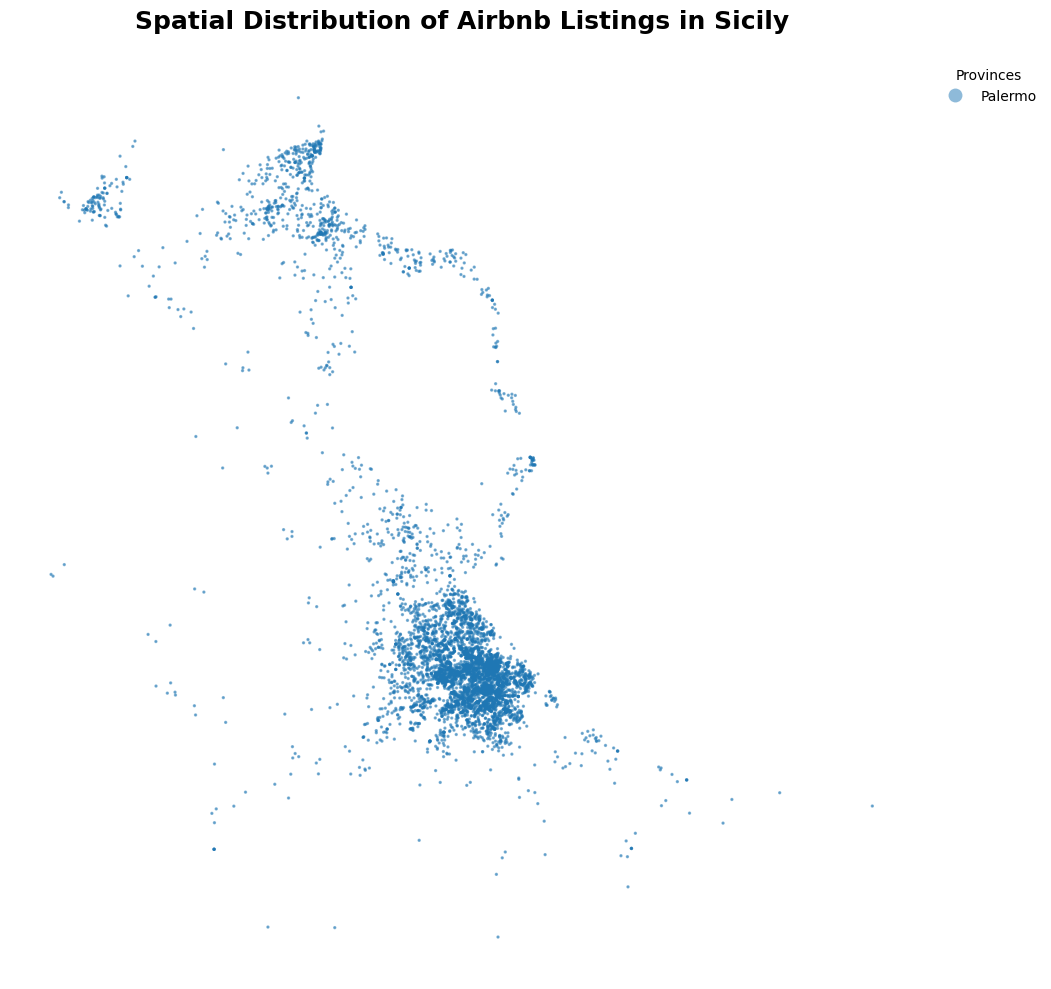

metre


In [40]:
# palermo scatter distribution
def plot_refined(data, title):
    fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')
    
    # 1. Plot points with high transparency and no edges to show "clusters"
    data.plot(
        column='neighbourhood_cleansed', 
        categorical=True, 
        cmap='tab20', 
        ax=ax, 
        markersize=2, # Tiny markers make it look like a density map
        alpha=0.5,
        legend=True,
        legend_kwds={'bbox_to_anchor': (1.15, 1), 'title': "Provinces", 'frameon': False}
    )
    
    # 2. Add a very faint grey boundary for the whole island if you have it
    # or just leave it clean
    
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(data.crs.axis_info[0].unit_name)
pm_gdf = pm_gdf.to_crs(epsg=3857)
plot_refined(pm_gdf, "Spatial Distribution of Airbnb Listings in Sicily")

### VISUALIZATIONS

In [10]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster, Fullscreen
from branca.colormap import linear

# Define the popup helper
def make_popup(row):
    return folium.Popup(f"""
        <div style="font-family: sans-serif; font-size: 12px; width: 200px;">
            <b>Name:</b> {row['name']}<br>
            <b>Price:</b> €{row['price']}<br>
            <b>Room:</b> {row['room_type']}<br>
            <b>Rating:</b> {row.get('review_scores_rating', 'N/A')}⭐
        </div>
    """, max_width=250)

# --- 2. MAP A: ALL SICILY (Overview) ---
# Strategy: Use FastMarkerCluster to keep the HTML file size small
m_sicily = folium.Map(
    location=[37.6, 14.0], 
    zoom_start=8, 
    tiles="cartodbpositron"
)

# Convert coordinates to list for the cluster
callback = ('function (row) {'
            'var marker = L.marker(new L.LatLng(row[0], row[1]));'
            'return marker;'
            '}')

# This allows 10,000+ points to load instantly as clusters
FastMarkerCluster(
    data=list(zip(listings_gdf.geometry.y, listings_gdf.geometry.x)),
    callback=callback,
    name="Airbnb in Sicily"
).add_to(m_sicily)

Fullscreen().add_to(m_sicily)
m_sicily.save("images/sicily_overview.html")


from branca.colormap import linear

# 1. Initialize Map centered on Palermo
m_palermo = folium.Map(
    location=[38.1157, 13.3615], 
    zoom_start=13, 
    tiles="cartodbpositron"
)

# 2. Add Palermo Borders
palermo_boundary = pm_gdf.dissolve().convex_hull
folium.GeoJson(
    palermo_boundary,
    name="Palermo City Boundary",
    style_function=lambda x: {
        'fillColor': 'none',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }
).add_to(m_palermo)

# 3. Enhanced Color Scale (Using Quantiles to avoid outlier stretching)
vmin = pm_gdf["log_price"].quantile(0.05)
vmax = pm_gdf["log_price"].quantile(0.95)

colormap = linear.RdYlGn_09.scale(vmin, vmax)
# Flip manually to get Green (Low) -> Red (High)
colormap.colors = colormap.colors[::-1] 

colormap.caption = f"Log Price ({vmin:.2f} to {vmax:.2f})"
colormap.add_to(m_palermo)

# 4. Plot Points
for room_type, df_room in pm_gdf.groupby("room_type"):
    feature_group = folium.FeatureGroup(name=room_type)
    
    for _, row in df_room.iterrows():
        # Clamp values for the colormap to handle outliers outside our 5-95 range
        val = max(min(row["log_price"], vmax), vmin)
        
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=3,
            color=None,
            fill=True,
            fill_color=colormap(val),
            fill_opacity=0.45,
            popup=make_popup(row),
            tooltip=str(row.get('name', 'Listing'))[:30]
        ).add_to(feature_group)
    
    feature_group.add_to(m_palermo)

folium.LayerControl(collapsed=False).add_to(m_palermo)
Fullscreen().add_to(m_palermo)

m_palermo.save("images/palermo_scatter_distribution.html")

print("Maps generated: images/sicily_overview.html and images/palermo_scatter_distribution.html")

Maps generated: images/sicily_overview.html and images/palermo_scatter_distribution.html


In [ ]:
import folium
from folium.plugins import HeatMap

def save_interactive_density_map(gdf, filename):
    """
    Creates an interactive HeatMap of listing density using Folium 
    and saves it as an HTML file.
    """
    # 1. Folium requires WGS84 (EPSG:4326) for plotting
    # Even if your math is in 32633, we convert back for the web map
    plot_gdf = gdf.to_crs(epsg=4326)
    
    # 2. Extract Lat/Long for the HeatMap (Folium uses [Lat, Lon] format)
    heat_data = [[point.y, point.x] for point in plot_gdf.geometry]
    
    # 3. Initialize the Map
    # We center it on the average coordinates of your data
    center_lat = plot_gdf.geometry.y.mean()
    center_lon = plot_gdf.geometry.x.mean()
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=13,
        tiles='CartoDB positron' # The clean "ScienceDirect" academic style
    )
    
    # 4. Add the HeatMap Layer
    # 'radius' controls the spread of the "glow"
    # 'blur' makes the transitions smoother
    HeatMap(
        heat_data, 
        radius=15, 
        blur=20, 
        min_opacity=0.3,
        gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'} # Classic heat gradient
    ).add_to(m)
    
    # 5. SAVE AS HTML
    m.save(filename)
    print(f"Interactive map saved as: {filename}")
    return m

save_interactive_density_map(listings_gdf, "images/sicily_density_map.html")
save_interactive_density_map(pm_gdf, "images/palermo_density_map.html")

Interactive map saved as: images/sicily_density_amp.html
Interactive map saved as: images/palermo_density_map.html
